In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
pred = np.array([[ 20.4122, 100.5985,  99.1256,   7.6130,   9.3668,   8.7651,  17.4485,
         14.2032,  19.2896,  11.2416,   7.3212,  20.2712,   3.5728,  13.5862,
         13.6634,  13.0425,  13.5121]])

In [80]:
pred_val = []
for i in range(pred.shape[1]):
    pred_val.append([])

In [83]:
for i in range(pred.shape[1]):
    pred_val[i].append(pred[0][i])
pred_val

[[20.4122, 20.4122, 20.4122],
 [100.5985, 100.5985, 100.5985],
 [99.1256, 99.1256, 99.1256],
 [7.613, 7.613, 7.613],
 [9.3668, 9.3668, 9.3668],
 [8.7651, 8.7651, 8.7651],
 [17.4485, 17.4485, 17.4485],
 [14.2032, 14.2032, 14.2032],
 [19.2896, 19.2896, 19.2896],
 [11.2416, 11.2416, 11.2416],
 [7.3212, 7.3212, 7.3212],
 [20.2712, 20.2712, 20.2712],
 [3.5728, 3.5728, 3.5728],
 [13.5862, 13.5862, 13.5862],
 [13.6634, 13.6634, 13.6634],
 [13.0425, 13.0425, 13.0425],
 [13.5121, 13.5121, 13.5121]]

In [22]:
df = pd.read_csv('/Users/jeonjunhwi/문서/Projects/Master_GNN/refference/Graph_neural_networks/con_state.csv', index_col='Date')

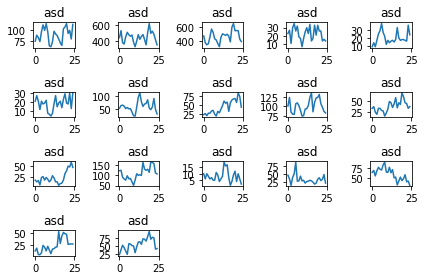

In [114]:
pred_val = np.array(pred_val)
fig = plt.figure()

for i in range(pred.shape[1]):
    fig.add_subplot(4,5,i+1)
    plt.plot(list(df.iloc[i,550:].values))
    plt.title('asd')

plt.tight_layout()

In [112]:
df.index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], dtype='int64', name='Date')

In [ ]:
pd.read_csv('/')